In [5]:
from copy import copy, deepcopy
from base64 import b64encode
import numpy as np
import cairocffi as cairo
import imageio
import colors

try:
    from cStringIO import StringIO
except ImportError:
    try:
        from StringIO import StringIO
    except ImportError:
        # Python 3 compatibility
        from io import BytesIO as StringIO


class Canvas:
    def __init__(self, width=640, height=480):
        self.width = width
        self.height = height
        self._cairo_surface = cairo.ImageSurface(cairo.FORMAT_ARGB32,
                                                 width, height)
        self.context = cairo.Context(self._cairo_surface)

    @staticmethod
    def from_image(image):
        """Initialize the surface from an np array of an image."""
        h, w, d = image.shape
        if d == 4:
            image = image[:, :, [2, 1, 0, 3]]
        if d == 1:
            image = np.array(3 * [image])
        elif d == 3:
            image = image[:, :, [2, 1, 0]]
            image = np.dstack([image, 255 * np.ones((h, w))])
        sf = Canvas(w, h)
        arr = np.frombuffer(sf._cairo_surface.get_data(), np.uint8)
        arr += image.flatten()
        sf._cairo_surface.mark_dirty()
        return sf

    def write_to_png(self, filename):
        imageio.imwrite(filename, self.get_npimage(True), format='png')

    def get_npimage(self, transparent=False, y_origin="top"):
        im = 0 + np.frombuffer(self._cairo_surface.get_data(), np.uint8)
        im.shape = (self.height, self.width, 4)
        im = im[:, :, [2, 1, 0, 3]]  # put RGB back in order
        if y_origin == "bottom":
            im = im[::-1]
        return im if transparent else im[:, :, :3]

    def get_html_embed_code(self, y_origin="top"):
        """Return an html code containing all the PNG data of the surface. """
        png_data = self._repr_png_()
        data = b64encode(png_data).decode('utf-8')
        return """<img  src="data:image/png;base64,%s">""" % (data)

    def ipython_display(self, y_origin="top"):
        from IPython.display import HTML
        return HTML(self.get_html_embed_code(y_origin=y_origin))

    def _repr_html_(self):
        return self.get_html_embed_code()

    def _repr_png_(self):
        """Return the raw PNG data to be displayed in the IPython notebook."""
        data = StringIO()
        self.write_to_png(data)
        return data.getvalue()

    def translate(self, x, y):
        self.context.translate(x, y)

    def center(self):
        self.context.identity_matrix()
        self.translate(self.width/2, self.height/2)

    def _set_source(self, src):
        if isinstance(src, int):
            if src > 0xffffff:
                self.context.set_source_rgba(((src & 0xff000000) >> 24) / 255.0, ((src & 0xff0000) >> 16) / 255.0, ((src & 0xff00) >> 8) / 255.0, (src & 0xff) / 255.0)
            else:
                self.context.set_source_rgb(((src & 0xff0000) >> 16) / 255.0, ((src & 0xff00) >> 8) / 255.0, (src & 0xff) / 255.0)
        elif len(src) == 4:
            self.context.set_source_rgba(*src)
        elif len(src) == 3:
            self.context.set_source_rgb(*src)

    def clear(self, color=colors.White):
        self.context.identity_matrix()
        self.context.rectangle(0, 0, self.width, self.height)
        self._set_source(color)
        self.context.fill()

    def line(self, p0, p1, color=colors.Black, width=2):
        self.context.move_to(*p0)
        self.context.line_to(*p1)
        self.context.set_line_width(width)
        self._set_source(color)
        self.context.stroke()

    def draw_axis(self, x=-1, y=-1):
        if x == -1:
            x = self.width / 2
        if y == -1:
            y = self.height / 2
        self.line((0, y), (self.width, y))
        self.line((x, 0), (x, self.height))

    def draw(self, e):
        self.context.save()
        e.draw(self.context)
        self.context.restore()

    def _draw_path(self, color=None, border=0, border_color=colors.Black):
        if color:
            self._set_source(color)
            if border > 0:
                self.context.fill_preserve()
            else:
                self.context.fill()
        if border > 0:
            self.context.set_line_width(border)
            self._set_source(border_color)
            self.context.stroke()

    def box(self, x, y, w, h, color=colors.White, border=2, border_color=colors.Black):
        self.context.rectangle(x, y, w, h)
        self._draw_path(color, border, border_color)
        return (x, y, w, h)

    def circle(self, x, y, r, fill=colors.White, border=2, border_color=colors.Black):
        self.context.move_to(x + r, y)
        self.context.arc(x, y, self.r, 0, 2 * np.pi)
        self._draw_path(fill, border, border_color)
        return (x-r, y-r, x+r*2, y+r*2)

    def text(self, x, y, text, fontsize=24, align='center', color=colors.Black):
        self.context.set_font_size(fontsize)
        if text is None:
            return
        text = str(text)
        if len(text) == 0:
            return
        xbear, ybear, w, h, xadvance, yadvance = self.context.text_extents(text)
        if align == 'center':
            x = x - w / 2 - xbear
            y = y - h / 2 - ybear
        elif align == 'left':
            x = x - xbear
            y = y - h / 2 - ybear
        elif align == 'right':
            x = x - w - xbear
            y = y - h / 2 - ybear
        elif align == 'top':
            x = x - w / 2 - xbear
            y = y - ybear
        elif align == 'bottom':
            x = x - w / 2 - xbear
            y = y - h - ybear
        self.context.move_to(x, y)
        self.context.text_path(text)
        self._draw_path(color, 0)
        return (x, y, w, h)

    def text_box(self, x, y, w, h, text, text_size=None, text_color=colors.Black, box_color=colors.White, border=2, border_color=colors.Black):
        ret = self.box(x, y, w, h, color=box_color, border = border, border_color=border_color)
        if text:
            if text_size is None:
                text_size = h-2
            self.text(x+w/2, y+h/2, text, text_size, color=text_color)
        return ret

    def text_box_list(self, x, y, w, h, texts, dir='v', text_size=None, text_color=colors.Black, box_color=colors.White, border=2, border_color=colors.Black):
        for i, text in enumerate(texts):
            tcolor =text_color
            if callable(text_color):
                tcolor = text_color(i, text)
            elif isinstance(text_color, list):
                tcolor = text_color[i%len(text_color)]
            bcolor = box_color
            if callable(box_color):
                bcolor = box_color(i, text)
            elif isinstance(box_color, list):
                bcolor = box_color[i%len(box_color)]
            px = x
            py = y
            if dir == 'v':
                py = y + i*h
            else:
                px = x + i*w
            self.text_box(px, py, w, h, text, text_size=text_size, text_color=tcolor, box_color=bcolor, border=border, border_color=border_color)
        if dir == 'v':
            return (x, y, w, h*len(texts))
        else:
            return (x, y, w*len(texts), h)

    def box_matrix(self, x, y, w, h, matrix, text_size=None, text_color=colors.Black, box_color=colors.White, border=2, border_color=colors.Black):
        for j, row in enumerate(matrix):
            for i, e in enumerate(row):
                tcolor = text_color
                if callable(text_color):
                    tcolor = text_color((j,i), e)
                elif isinstance(text_color, list):
                    tcolor = text_color[j][i]
                bcolor = box_color
                if callable(box_color):
                    bcolor = box_color((j,i), e)
                elif isinstance(box_color, list):
                    bcolor = box_color[j][i]
                self.text_box(x+i*w, y+j*h, w, h, e, text_size=text_size, text_color=tcolor, box_color=bcolor, border=border,
                              border_color=border_color)
        return (x, y, w*len(matrix[0]), h*len(matrix))

    def text_align_to(self, bbox, text, fontsize=24, align='top', color=colors.Black, padding=4):
        x, y, w, h = bbox
        if align == 'left':
            return self.text(x-padding, y+h/2, text, fontsize=fontsize, align='right', color=color)
        elif align == 'right':
            return self.text(x+w+padding, y+h/2, text, fontsize=fontsize, align='left', color=color)
        elif align == 'top':
            return self.text(x+w/2, y-padding, text, fontsize=fontsize, align='bottom', color=color)
        elif align == 'bottom':
            return self.text(x+w/2, y+h+padding, text, fontsize=fontsize, align='top', color=color)
        else:
            raise Exception('illegal align type')



In [6]:
sf = Canvas(640, 480)


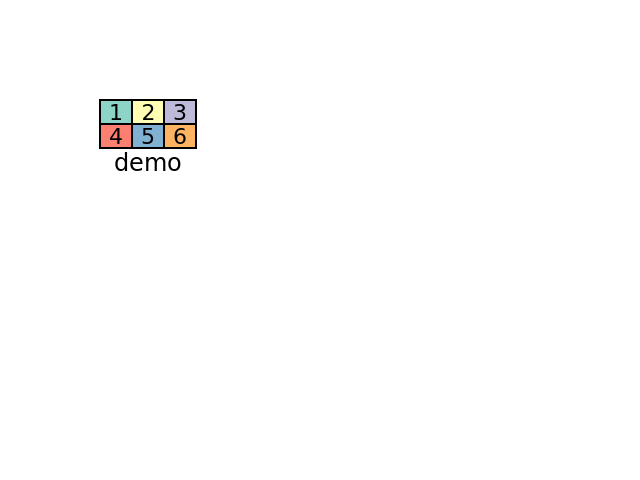

In [7]:
from colors import Set3
def mc(ji, e):
    return Set3[ji[0]*3+ji[1]]
sf.clear()
a = [[1,2,3],[4,5,6]]
bbox = sf.box_matrix(100,100,32,24,a, box_color=mc)
sf.text_align_to(bbox, 'demo', 24, align='bottom')
sf.ipython_display()

In [1]:
def b():
    for i in range(5):
        yield i

def a():
    for i in range(10):
        b()

        
for i in b():
    print(i)


0
1
2
3
4
